# TP3 - Exercise 4: Matrix Multiplication Performance Analysis

This notebook analyzes the performance of parallel matrix multiplication using OpenMP with:
1. Performance scaling with different thread counts
2. Speedup and efficiency analysis
3. Scheduling policy comparison (STATIC, DYNAMIC, GUIDED)

## Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

Load the results from thread scaling and scheduling experiments.

In [2]:
# Load thread results
thread_df = pd.read_csv('thread_results.txt')
print("Thread Scaling Results:")
print(thread_df)
print(f"\nSerial time (1 thread): {thread_df.loc[0, 'time']:.6f} seconds")

Thread Scaling Results:
   threads      time
0        1  5.894046
1        2  3.054714
2        4  2.104565
3        8  1.214343
4       16  1.207019

Serial time (1 thread): 5.894046 seconds


In [3]:
# Load scheduling results
scheduling_df = pd.read_csv('scheduling_results.txt')
print("\nScheduling Policy Results (8 threads):")
print(scheduling_df)
print(f"\nNumber of scheduling configurations tested: {len(scheduling_df)}")


Scheduling Policy Results (8 threads):
    threads schedule  chunk_size      time
0         8   static          10  1.373804
1         8   static          25  1.234536
2         8   static          50  1.396565
3         8   static         100  1.559694
4         8   static         250  1.258836
5         8   static         500  1.249564
6         8  dynamic          10  1.275768
7         8  dynamic          25  1.340636
8         8  dynamic          50  1.219150
9         8  dynamic         100  1.512907
10        8  dynamic         250  1.265034
11        8  dynamic         500  1.224108
12        8   guided          10  1.694637
13        8   guided          25  1.281728
14        8   guided          50  1.738086
15        8   guided         100  1.260171
16        8   guided         250  1.366988
17        8   guided         500  1.237116

Number of scheduling configurations tested: 18


## Calculate Performance Metrics

Calculate speedup and efficiency for different thread counts:
- **Speedup** = T_serial / T_parallel
- **Efficiency** = (Speedup / threads) × 100%

In [4]:
# Get serial time (1 thread)
T_serial = thread_df.loc[0, 'time']

# Calculate speedup and efficiency
thread_df['speedup'] = T_serial / thread_df['time']
thread_df['efficiency'] = (thread_df['speedup'] / thread_df['threads']) * 100

# Calculate ideal speedup for comparison
thread_df['ideal_speedup'] = thread_df['threads']

print("Performance Metrics:")
print(thread_df.to_string(index=False))

Performance Metrics:
 threads     time  speedup  efficiency  ideal_speedup
       1 5.894046 1.000000  100.000000              1
       2 3.054714 1.929492   96.474596              2
       4 2.104565 2.800601   70.015015              4
       8 1.214343 4.853691   60.671141              8
      16 1.207019 4.883143   30.519642             16


## Plot 1: Speedup Analysis

Compare actual speedup vs ideal linear speedup.

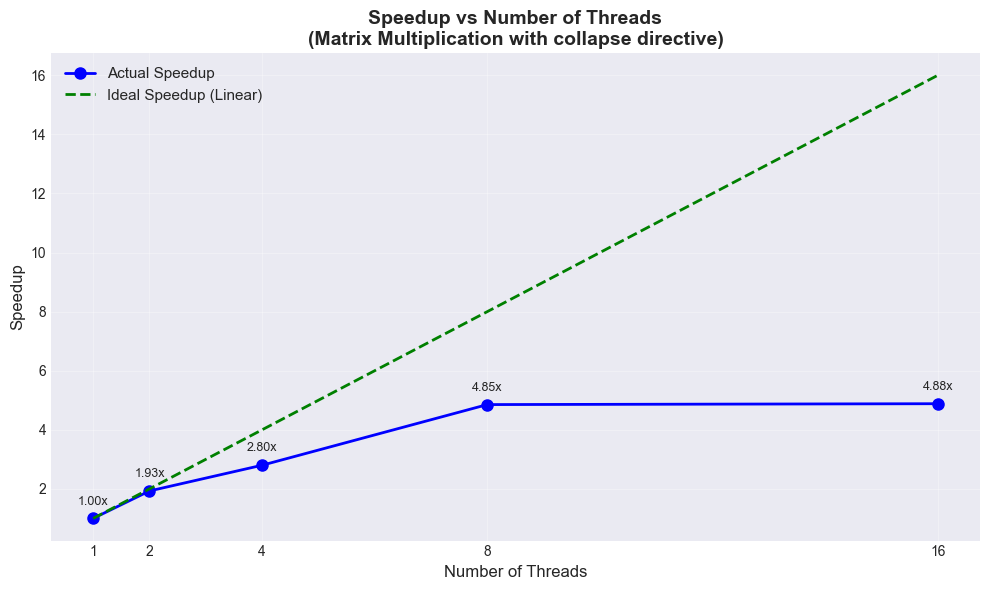

Maximum speedup: 4.88x with 16 threads


In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual speedup
ax.plot(thread_df['threads'], thread_df['speedup'], 
        marker='o', linewidth=2, markersize=8, 
        label='Actual Speedup', color='blue')

# Plot ideal speedup
ax.plot(thread_df['threads'], thread_df['ideal_speedup'], 
        linestyle='--', linewidth=2, 
        label='Ideal Speedup (Linear)', color='green')

ax.set_xlabel('Number of Threads', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Speedup vs Number of Threads\n(Matrix Multiplication with collapse directive)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(thread_df['threads'])

# Add values on points
for i, row in thread_df.iterrows():
    ax.annotate(f"{row['speedup']:.2f}x", 
                (row['threads'], row['speedup']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9)

plt.tight_layout()
plt.savefig('speedup_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Maximum speedup: {thread_df['speedup'].max():.2f}x with {thread_df.loc[thread_df['speedup'].idxmax(), 'threads']} threads")

## Plot 2: Efficiency Analysis

Show how efficiently threads are utilized as thread count increases.

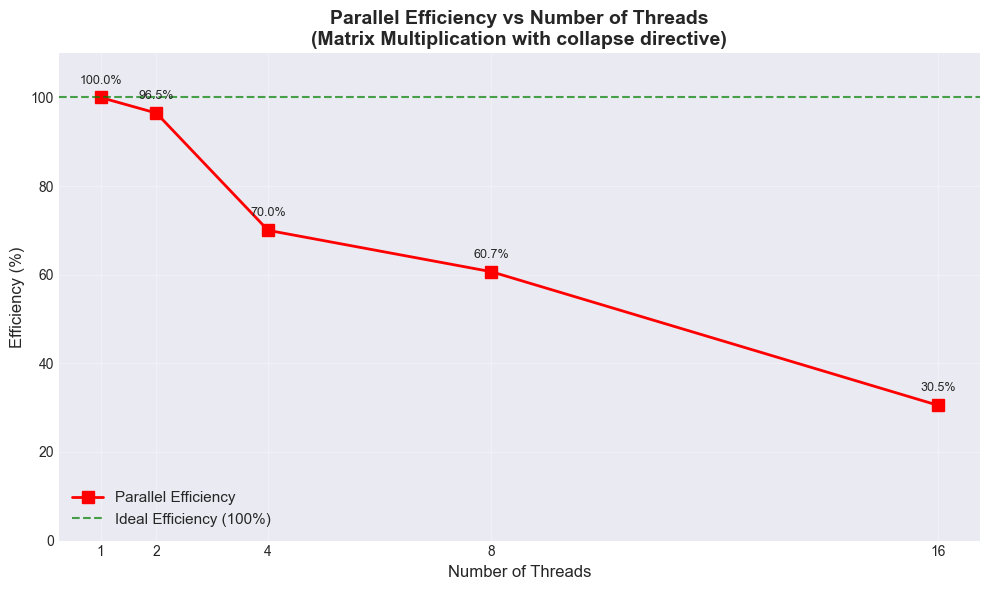

Efficiency at 16 threads: 30.52%


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot efficiency
ax.plot(thread_df['threads'], thread_df['efficiency'], 
        marker='s', linewidth=2, markersize=8, 
        label='Parallel Efficiency', color='red')

# Add 100% efficiency line
ax.axhline(y=100, linestyle='--', linewidth=1.5, 
           color='green', label='Ideal Efficiency (100%)', alpha=0.7)

ax.set_xlabel('Number of Threads', fontsize=12)
ax.set_ylabel('Efficiency (%)', fontsize=12)
ax.set_title('Parallel Efficiency vs Number of Threads\n(Matrix Multiplication with collapse directive)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(thread_df['threads'])
ax.set_ylim(0, 110)

# Add values on points
for i, row in thread_df.iterrows():
    ax.annotate(f"{row['efficiency']:.1f}%", 
                (row['threads'], row['efficiency']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9)

plt.tight_layout()
plt.savefig('efficiency_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Efficiency at 16 threads: {thread_df.loc[thread_df['threads']==16, 'efficiency'].values[0]:.2f}%")

## Plot 3: Scheduling Policy Comparison

Compare execution times for different scheduling policies (STATIC, DYNAMIC, GUIDED) with various chunk sizes.

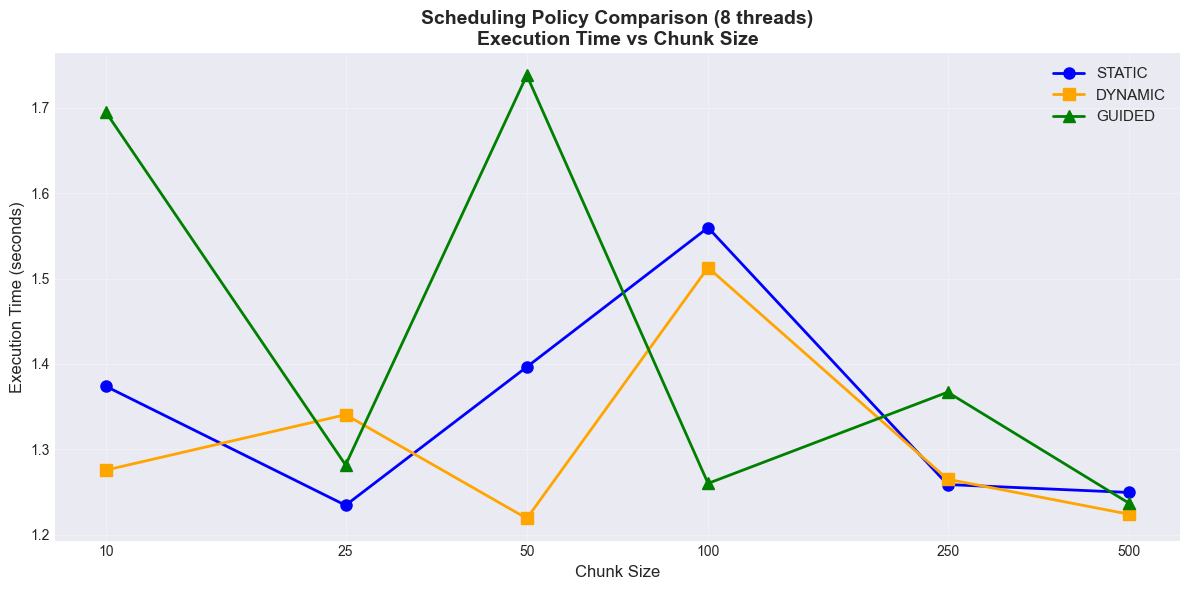

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

# Group by schedule type
schedules = scheduling_df['schedule'].unique()
colors = {'static': 'blue', 'dynamic': 'orange', 'guided': 'green'}
markers = {'static': 'o', 'dynamic': 's', 'guided': '^'}

for schedule in schedules:
    df_sched = scheduling_df[scheduling_df['schedule'] == schedule]
    ax.plot(df_sched['chunk_size'], df_sched['time'], 
            marker=markers[schedule], linewidth=2, markersize=8,
            label=schedule.upper(), color=colors[schedule])

ax.set_xlabel('Chunk Size', fontsize=12)
ax.set_ylabel('Execution Time (seconds)', fontsize=12)
ax.set_title('Scheduling Policy Comparison (8 threads)\nExecution Time vs Chunk Size', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_xticks([10, 25, 50, 100, 250, 500])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.savefig('scheduling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Summary: Best Configurations

In [8]:
print("="*60)
print("SCHEDULING POLICY ANALYSIS")
print("="*60)

for schedule in schedules:
    df_sched = scheduling_df[scheduling_df['schedule'] == schedule]
    best_idx = df_sched['time'].idxmin()
    worst_idx = df_sched['time'].idxmax()
    
    print(f"\n{schedule.upper()} Scheduling:")
    print(f"  Best:  chunk={df_sched.loc[best_idx, 'chunk_size']:3d} -> {df_sched.loc[best_idx, 'time']:.6f}s")
    print(f"  Worst: chunk={df_sched.loc[worst_idx, 'chunk_size']:3d} -> {df_sched.loc[worst_idx, 'time']:.6f}s")
    print(f"  Avg:   {df_sched['time'].mean():.6f}s")
    print(f"  Std:   {df_sched['time'].std():.6f}s")

# Find overall best configuration
best_config_idx = scheduling_df['time'].idxmin()
best_config = scheduling_df.loc[best_config_idx]

print("\n" + "="*60)
print("OVERALL BEST CONFIGURATION")
print("="*60)
print(f"Schedule:   {best_config['schedule'].upper()}")
print(f"Chunk Size: {best_config['chunk_size']}")
print(f"Time:       {best_config['time']:.6f}s")
print(f"Speedup:    {T_serial/best_config['time']:.2f}x (vs serial time)")

SCHEDULING POLICY ANALYSIS

STATIC Scheduling:
  Best:  chunk= 25 -> 1.234536s
  Worst: chunk=100 -> 1.559694s
  Avg:   1.345500s
  Std:   0.125152s

DYNAMIC Scheduling:
  Best:  chunk= 50 -> 1.219150s
  Worst: chunk=100 -> 1.512907s
  Avg:   1.306267s
  Std:   0.110319s

GUIDED Scheduling:
  Best:  chunk=500 -> 1.237116s
  Worst: chunk= 50 -> 1.738086s
  Avg:   1.429788s
  Std:   0.226694s

OVERALL BEST CONFIGURATION
Schedule:   DYNAMIC
Chunk Size: 50
Time:       1.219150s
Speedup:    4.83x (vs serial time)


## Combined Visualization: All Metrics

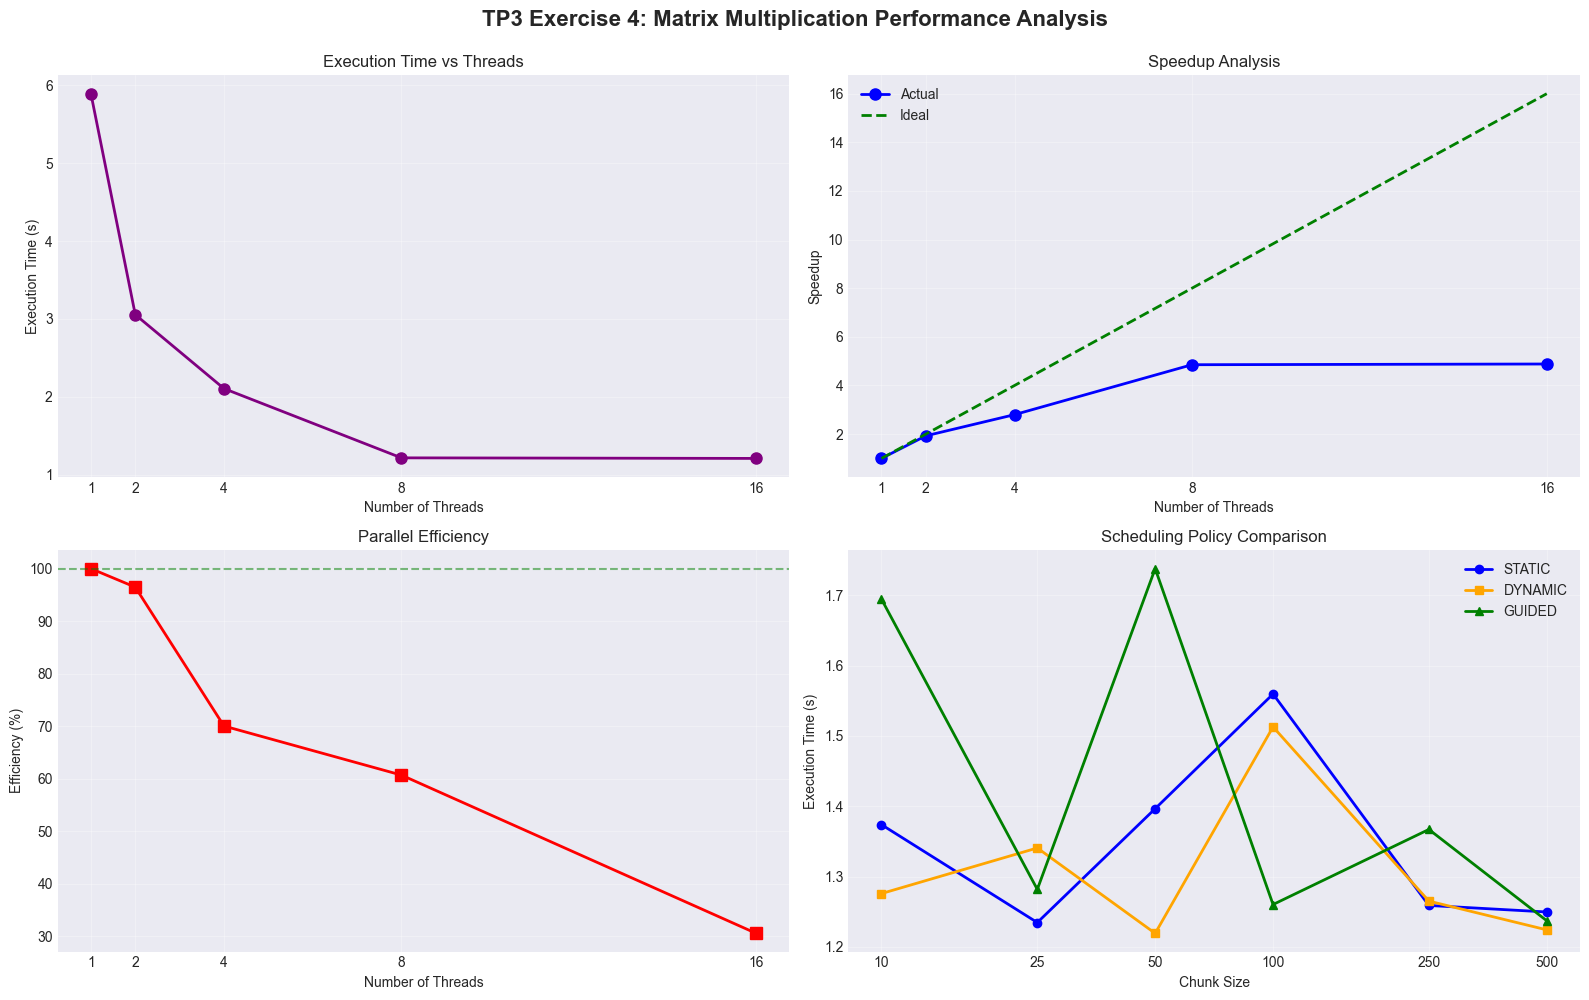

In [9]:
fig = plt.figure(figsize=(16, 10))

# Plot 1: Execution Time vs Threads
ax1 = plt.subplot(2, 2, 1)
ax1.plot(thread_df['threads'], thread_df['time'], 
         marker='o', linewidth=2, markersize=8, color='purple')
ax1.set_xlabel('Number of Threads')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Threads')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(thread_df['threads'])

# Plot 2: Speedup
ax2 = plt.subplot(2, 2, 2)
ax2.plot(thread_df['threads'], thread_df['speedup'], 
         marker='o', linewidth=2, markersize=8, label='Actual', color='blue')
ax2.plot(thread_df['threads'], thread_df['ideal_speedup'], 
         linestyle='--', linewidth=2, label='Ideal', color='green')
ax2.set_xlabel('Number of Threads')
ax2.set_ylabel('Speedup')
ax2.set_title('Speedup Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(thread_df['threads'])

# Plot 3: Efficiency
ax3 = plt.subplot(2, 2, 3)
ax3.plot(thread_df['threads'], thread_df['efficiency'], 
         marker='s', linewidth=2, markersize=8, color='red')
ax3.axhline(y=100, linestyle='--', color='green', alpha=0.5)
ax3.set_xlabel('Number of Threads')
ax3.set_ylabel('Efficiency (%)')
ax3.set_title('Parallel Efficiency')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(thread_df['threads'])

# Plot 4: Scheduling Comparison
ax4 = plt.subplot(2, 2, 4)
for schedule in schedules:
    df_sched = scheduling_df[scheduling_df['schedule'] == schedule]
    ax4.plot(df_sched['chunk_size'], df_sched['time'], 
            marker=markers[schedule], linewidth=2, markersize=6,
            label=schedule.upper(), color=colors[schedule])
ax4.set_xlabel('Chunk Size')
ax4.set_ylabel('Execution Time (s)')
ax4.set_title('Scheduling Policy Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xscale('log')
ax4.set_xticks([10, 25, 50, 100, 250, 500])
ax4.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.suptitle('TP3 Exercise 4: Matrix Multiplication Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings Summary

In [10]:
print("\n" + "="*70)
print("KEY FINDINGS - TP3 EXERCISE 4")
print("="*70)

print("\n1. THREAD SCALING:")
print(f"   - Serial time (1 thread): {T_serial:.3f}s")
print(f"   - Best parallel time (16 threads): {thread_df.loc[thread_df['threads']==16, 'time'].values[0]:.3f}s")
print(f"   - Maximum speedup achieved: {thread_df['speedup'].max():.2f}x")
print(f"   - Efficiency at 16 threads: {thread_df.loc[thread_df['threads']==16, 'efficiency'].values[0]:.1f}%")

print("\n2. COLLAPSE DIRECTIVE EFFECTIVENESS:")
speedup_8 = thread_df.loc[thread_df['threads']==8, 'speedup'].values[0]
print(f"   - With 8 threads: {speedup_8:.2f}x speedup")
print(f"   - Collapse(2) enables parallel work distribution over 2 nested loops")
print(f"   - Better load balancing compared to parallelizing single loop")

print("\n3. SCHEDULING POLICY RECOMMENDATIONS:")
for schedule in schedules:
    df_sched = scheduling_df[scheduling_df['schedule'] == schedule]
    best_chunk = df_sched.loc[df_sched['time'].idxmin(), 'chunk_size']
    best_time = df_sched['time'].min()
    print(f"   - {schedule.upper():7s}: Best with chunk={best_chunk:3d} ({best_time:.3f}s)")

print("\n4. OVERALL RECOMMENDATION:")
print(f"   - Best configuration: {best_config['schedule'].upper()}, chunk={best_config['chunk_size']}")
print(f"   - Achieved {T_serial/best_config['time']:.2f}x speedup over serial execution")

print("\n" + "="*70)


KEY FINDINGS - TP3 EXERCISE 4

1. THREAD SCALING:
   - Serial time (1 thread): 5.894s
   - Best parallel time (16 threads): 1.207s
   - Maximum speedup achieved: 4.88x
   - Efficiency at 16 threads: 30.5%

2. COLLAPSE DIRECTIVE EFFECTIVENESS:
   - With 8 threads: 4.85x speedup
   - Collapse(2) enables parallel work distribution over 2 nested loops
   - Better load balancing compared to parallelizing single loop

3. SCHEDULING POLICY RECOMMENDATIONS:
   - STATIC : Best with chunk= 25 (1.235s)
   - DYNAMIC: Best with chunk= 50 (1.219s)
   - GUIDED : Best with chunk=500 (1.237s)

4. OVERALL RECOMMENDATION:
   - Best configuration: DYNAMIC, chunk=50
   - Achieved 4.83x speedup over serial execution

